Run this code strictly in Colab.
Use the images given.
Install the neccessary libraries.

In [4]:
!pip install numpy --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-8-69939bf09014>:68: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
<ipython-input-8-69939bf09014>:73: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))


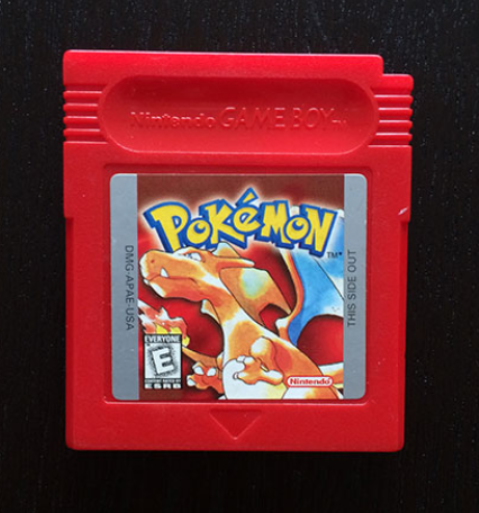

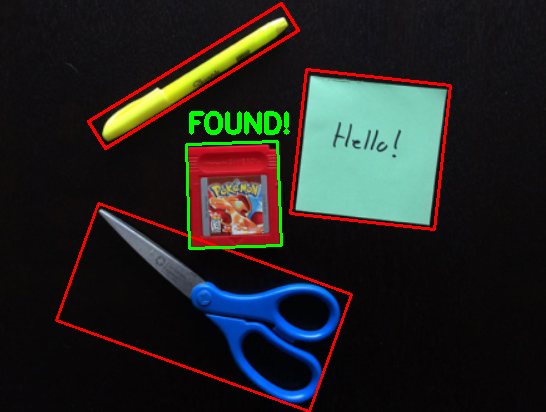

-1

In [8]:
# import the necessary packages
from scipy.spatial import distance as dist
import numpy as np
import mahotas
import cv2
from google.colab.patches import cv2_imshow as cvim
import imutils
  
def describe_shapes(image):
    # initialize the list of shape features
    shapeFeatures = []
  
    # convert the image to grayscale, blur it, and threshold it
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)
    thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]
  
    # perform a series of dilations and erosions to close holes
    # in the shapes
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.erode(thresh, None, iterations=2)
  
    # detect contours in the edge map
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
  
    # loop over the contours
    for c in cnts:
        # create an empty mask for the contour and draw it
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
  
        # extract the bounding box ROI from the mask
        (x, y, w, h) = cv2.boundingRect(c)
        roi = mask[y:y + h, x:x + w]
  
        # compute Zernike Moments for the ROI and update the list
        # of shape features
        features = mahotas.features.zernike_moments(roi, cv2.minEnclosingCircle(c)[1], degree=8)
        shapeFeatures.append(features)
  
    # return a tuple of the contours and shapes
    return (cnts, shapeFeatures)
 
# load the reference image containing the object we want to detect,
# then describe the game region
refImage = cv2.imread("/content/pokemon_red.png")
(_, gameFeatures) = describe_shapes(refImage)
  
# load the shapes image, then describe each of the images in the image
shapesImage = cv2.imread("/content/shapes.png")
(cnts, shapeFeatures) = describe_shapes(shapesImage)
  
# compute the Euclidean distances between the video game features
# and all other shapes in the second image, then find index of the
# smallest distance
D = dist.cdist(gameFeatures, shapeFeatures)
i = np.argmin(D)
 
# loop over the contours in the shapes image
for (j, c) in enumerate(cnts):
    # if the index of the current contour does not equal the index
    # contour of the contour with the smallest distance, then draw
    # it on the output image
    if i != j:
        box = cv2.minAreaRect(c)
        box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
        cv2.drawContours(shapesImage, [box], -1, (0, 0, 255), 2)
  
# draw the bounding box around the detected shape
box = cv2.minAreaRect(cnts[i])
box = np.int0(cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box))
cv2.drawContours(shapesImage, [box], -1, (0, 255, 0), 2)
(x, y, w, h) = cv2.boundingRect(cnts[i])
cv2.putText(shapesImage, "FOUND!", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
    (0, 255, 0), 3)
  
# show the output images
cvim(refImage)
cvim(shapesImage)
cv2.waitKey(0)